# Infeasibility analysis on a cluster

Perform a simple analysis on the results of a UQ evaluation on a cluster using Dask.

In [1]:
import easyvvuq as uq
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
print("Reading in campaign database.")

# Find DB
db_count = 0
for db_path in Path.cwd().glob("campaigns/*/campaign.db"):
    if db_count > 0:
        raise RuntimeError("More than one database in the campaigns dir")

    db_location = str(db_path.resolve())
    db_count += 1

# /// prefix is required before absolute path
db_location_prefixed = f"sqlite:///{db_location}"
campaign = uq.Campaign(
    db_location=db_location_prefixed, name="example_cluster", work_dir="campaigns"
)

samples = campaign.get_collation_result()
sample_count = samples.shape[0]
print(f"Campaign read in. Number of samples = {sample_count}")

# Drop strange multi-index of 0
samples.columns = samples.columns.droplevel(1)
samples

Reading in campaign database.
Campaign read in. Number of samples = 256


,run_id,iteration,aspect,triang,psepbqarmax,hfact,fdene,coreradius,fimp_2,fimp_14,...,feffcd,etath,etaiso,boundl_18,pinjalw,alstroh,sig_tf_wp_max,boundu_2,vary_param,rms_vio_constr_res
0,1,0,3.013886,0.413886,8.769432,1.013886,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.113375
1,2,0,3.013886,0.413886,8.769432,1.066002,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.112349
2,3,0,3.013886,0.413886,8.769432,1.133998,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.111968
3,4,0,3.013886,0.413886,8.769432,1.186114,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.112222
4,5,0,3.013886,0.413886,9.030009,1.013886,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.110972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,252,0,3.186114,0.586114,9.369991,1.186114,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.086786
252,253,0,3.186114,0.586114,9.630568,1.013886,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.085817
253,254,0,3.186114,0.586114,9.630568,1.066002,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.084325
254,255,0,3.186114,0.586114,9.630568,1.133998,1.2,0.75,0.1,0.00001,...,1.0,0.375,0.9,3.25,61.0,660000000.0,640000000.0,12.0,,0.083676



## Plot some samples

The most basic analysis.


Text(0.5, 1.0, 'Variability in vio_constr_res against aspect ratio')

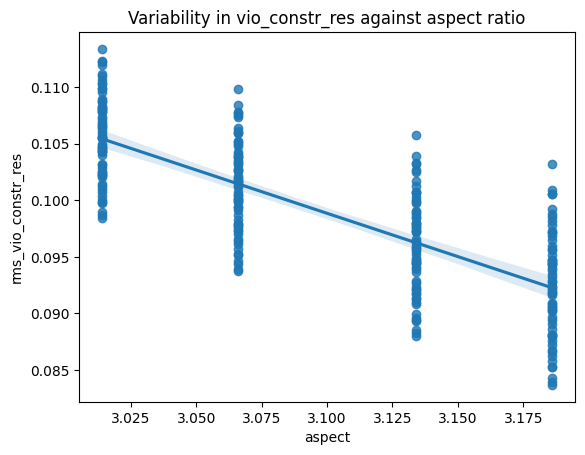

In [3]:
# Plot 2 vars from sample against each other
# Input epistemic uncertainty aspect against vio_constr_res
ax = sns.regplot(x=samples["aspect"], y=samples["rms_vio_constr_res"])
ax.set_xlabel("aspect")
ax.set_ylabel("rms_vio_constr_res")
ax.set_title("Variability in vio_constr_res against aspect ratio")

## Analysis

Analyse vio_constr_residuals, the violated constraint residuals.

### KDE for `vio_constr_res` from EasyVVUQ (plotted with seaborn)


Text(0, 0.5, 'Probability density')

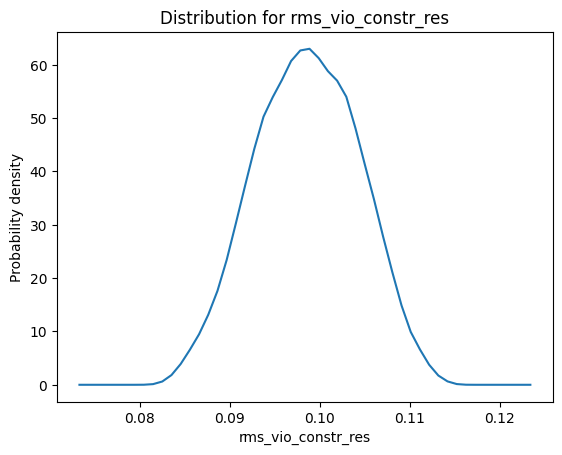

In [4]:
# Try to analyse all outputs variables: produces a linalg error
# results = campaign.analyse(qoi_cols=palph2_inputs)

# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["rms_vio_constr_res"])

# Get its distribution
dist = results.get_distribution(qoi="rms_vio_constr_res")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0])
pdf = dist.pdf(x)

# Plot
ax = sns.lineplot(x=x, y=pdf, markers=True)
ax.set_title("Distribution for rms_vio_constr_res")
ax.set_xlabel("rms_vio_constr_res")
ax.set_ylabel("Probability density")

PDF for `vio_constr_res`. Appears right from looking at the EasyVVUQ tutorial (fusion Dask).

## Sobol indices


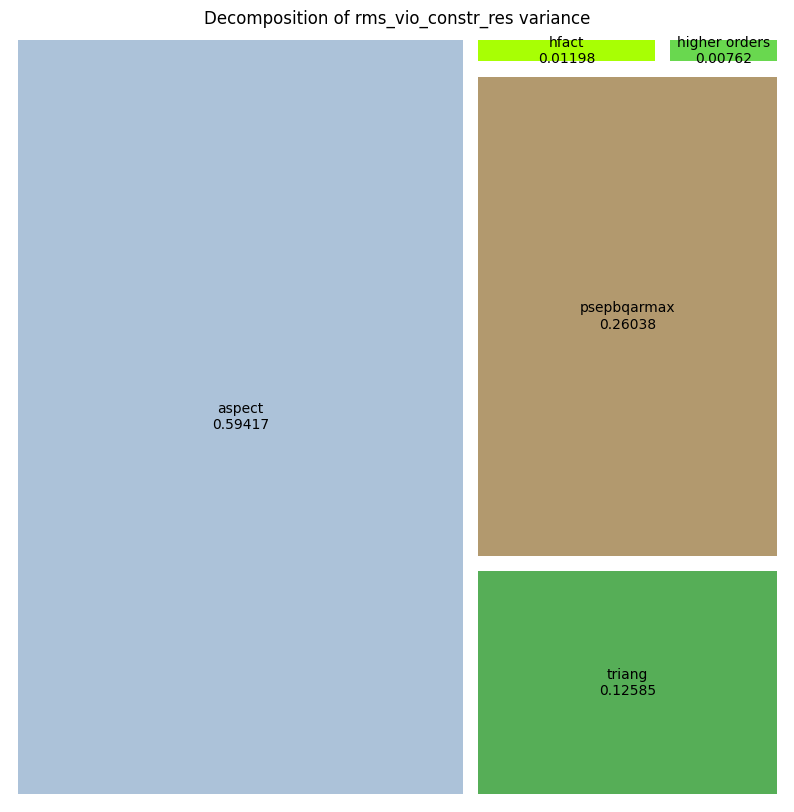

In [5]:
# results.plot_moments(qoi="vio_constr_res")
# results.plot_sobols_first("vio_constr_res") # only for vecotr qois. Like constraint vectors?

fig, ax = plt.subplots()
results.plot_sobols_treemap(
    "rms_vio_constr_res", figsize=(10, 10), ax=ax, filename="sobols"
)